# $\mathbf{IDENTIFYING}$ $\mathbf{STELLAR}$ $\mathbf{CANDIDATES}$ $\mathbf{WITH}$ $\mathbf{EARTHLIKE}$ $\mathbf{SATELLITES}$
## *Do stars that have 'Earthlike' planets have certain characteristics?*  
## *Can we determine if a star has Earthlike planets based on these characteristics?*
### Prepared for The Planetary Society's Summer Forum
$\rightarrow$Report by Ryan Miller, Data Scientist | 7/6/2022

----

# $\bigstar$ Executive Summary

### Question: [Exoplanets](https://en.wikipedia.org/wiki/Exoplanet) are planets outside of our solar system and we're entering a new era of exoplanet discovery with the [James Webb Space Telescope (JWST)](https://www.jwst.nasa.gov/) coming online.  Expanding on the Kepler telescope and a number of other telescopes/missions geared towards exoplanet discovery, the JWST will allow humanity to glimpse further into the unverse than ever before; but, it can also get amazing detail of things much closer.  In fact, under certain conditions, it can 'see' an extrasolar planet's atmosphere, possibly detecting telltale signs of life.  As such, with so many stars in our galaxy alone (~100 Billion) and assets limited to one telescope, can we identify stellar candidates that have 'Earthlike' planets to focus our attention on?
##### Note: For this study, I defined 'Earthlike' as planets that have a gravity level that could support earth-like life, as this will present the most familiar signs of organic activity for identification .  Details of how this was determined can be found in this notebook. 
### Actions: Using [exoplanet telescope data consolidated by CalTech](https://exoplanetarchive.ipac.caltech.edu/), I attempted to filter and identify key characteristics of stars with earthlike planets - with the goal of identifying planets which would most likely harbor detectable life.  As such, I did a detailed analysis of the best data I could put together on every planet so far discovered to see if there were any clear drivers of having earthlike planets.  Modeling was attempted to see if an ML Classification Model could be used to classify new and existing stellar candidates.
### Conclusions:  Even with extensive analysis, there was not much success in identifying clear characteristics of stars which harbor Earthlike planets.  Modeling also failed to improve on baseline.  Overall this is not surprising as this is a very new field stretching cutting edge instruments to their furtherst capabilities.
### Recommendations: Continue to cluster stellar characteristics in an attempt to find one statistically signifigant as an indicator of Earthlike planets.  Also, an imputing algorithm can be used to capture a number of planets that had nulls that could not be filled simply by combing and finding the mean of all available data for that planet.  Lastly, focus early JWST studies on building a dataset which allows for modeling the likelihood of a star having an earthlike planet, as this will make it a better tool in the long run by continually improving its targeting.

----

# $\bigstar$ Libraries Required for Analysis

Common DS Libraries

In [1]:
# For data analysis:
import numpy as np
import pandas as pd

# Graphs/Visualizations:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For Statistics and Hypothesis Testing:
import scipy.stats as stats

# For Modeling:
from itertools import combinations
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Internally Created Helper Functions

In [2]:
# For acquiring the dataset from the Cal Tech Database:
from acquire import acquire_exoplanet_data as aed

# For preparing and cleaning as well as splitting and encoding the dataset
# and seperating into new df, X_train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test:
import wrangle

# For running bivariate and multivariate graphical comparisons
import explore

# For comparing Classification Algorithm Outcomes
from matrix_result import matrix_result_2d

Others

In [3]:
#Ignore Warnings:
import warnings
warnings.filterwarnings('ignore')

# reloads import files each time a cell is ran (makes your life easier)
%load_ext autoreload
%autoreload 2

# Shows all columns of a dataframe
pd.set_option('display.max_columns', None)

# $\bigstar$ Data Acquisition and Summary Analysis

## After initially exploring a [kaggle dataset](https://www.kaggle.com/datasets/shivamb/all-exoplanets-dataset), already somewhat prepped, I discovered it was pulled from a larger raw dataset from CalTech.  I explored [CalTech's data](https://exoplanetarchive.ipac.caltech.edu/) and determined it would be better to pull directly from there, although it meant an initial manual filtering of 373 columns.
### The columns chosen were primarily characteristics of the planet and the star they orbited.
### It was not a straight download, nor was there an API call, but rather you create a SQL-like query when calling the url to produce a csv, found here: https://exoplanetarchive.ipac.caltech.edu/docs/TAP/usingTAP.html

Downloaded 6/29/2022

- *See 'exoplanet_acquire_workbook.ipynb' for more details on process*

## Raw Data Features Acquired:
- 'hostname': host star's name
- 'pl_letter': planet's letter, determined by order around planet in which it was discovered
- 'sy_snum': number of stars in planetary system (single, binary, ternary, four-star)
- 'sy_pnum': number of planets in system (equals number of letters)
- 'cb_flag': systems flagged as binary sar systems
- 'disoverymethod': method of exoplanet discovery 
- 'disc_year': year planet discovered
- 'glat': galactic latitude, from earth as origin
- 'glon': galatic longitude, from earth as origin
- 'pl_orbper': period of planet orbit around star
- 'sy_gaiamag': magnitude of star (from Gaia probe instrument)
- 'pl_controv_flag': flag for planets with controversial data
- 'pl_dens': density of planet
- 'pl_rade': planet's radius
- 'pl_ratdor': planet's ratio of it's star's radius to it's orbit
- 'pl_masse': planet's mass
- 'st_teff': star's temperature, in Kelvin     
- 'st_met': star's mettalicity
- 'st_lum': star's luminosity
- 'st_logg': log of star's gravity
- 'st_age': star's age, in Billions of years
- 'st_mass': star's mass, in relation to the Sun
- 'st_dens': star's density, in g/cm^3
- 'st_rad': star's radius, in relation to the Sun
- 'sy_dist': star's distance from earth
- 'rowupdate': when the observation was added

## Loading the raw dataset in:

In [4]:
# Load raw dataset and get info and head
df = aed()
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32552 entries, 0 to 32551
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hostname         32552 non-null  object 
 1   pl_letter        32552 non-null  object 
 2   sy_snum          32552 non-null  int64  
 3   sy_pnum          32552 non-null  int64  
 4   cb_flag          32552 non-null  int64  
 5   discoverymethod  32552 non-null  object 
 6   disc_year        32552 non-null  int64  
 7   glat             32552 non-null  float64
 8   glon             32552 non-null  float64
 9   pl_orbper        29747 non-null  float64
 10  sy_gaiamag       31884 non-null  float64
 11  pl_controv_flag  32552 non-null  int64  
 12  pl_dens          1626 non-null   float64
 13  pl_rade          22711 non-null  float64
 14  pl_ratdor        15519 non-null  float64
 15  pl_masse         2781 non-null   float64
 16  st_teff          30688 non-null  float64
 17  st_met      

,hostname,pl_letter,sy_snum,sy_pnum,cb_flag,discoverymethod,disc_year,glat,glon,pl_orbper,sy_gaiamag,pl_controv_flag,pl_dens,pl_rade,pl_ratdor,pl_masse,st_teff,st_met,st_lum,st_logg,st_age,st_mass,st_dens,st_rad,sy_dist,rowupdate
0,Kepler-11,c,1,6,0,Transit,2010,8.13328,76.1613,13.02502,13.7062,0,NaN,3.15,NaN,13.5,5680.0,0.0,NaN,4.3,8.0,0.95,NaN,1.1,646.346,2014-05-16
1,Kepler-11,f,1,6,0,Transit,2010,8.13328,76.1613,46.68876,13.7062,0,NaN,2.61,NaN,2.3,5680.0,0.0,NaN,4.3,8.0,0.95,NaN,1.1,646.346,2014-05-16


### There are a lot more rows here than the previous dataset.  I know that ~5k exoplanets have been discovered so this dataset represents 6x this number of observations.  Many might be duplicates.

For example:

In [5]:
# Showing how many observations for a single star with 6 identified planets (it's 36 - 6x6)
df[df.hostname == 'Kepler-11']
df[df.hostname == 'Kepler-11'].groupby(df.pl_letter).mean()

,sy_snum,sy_pnum,cb_flag,disc_year,glat,glon,pl_orbper,sy_gaiamag,pl_controv_flag,pl_dens,pl_rade,pl_ratdor,pl_masse,st_teff,st_met,st_lum,st_logg,st_age,st_mass,st_dens,st_rad,sy_dist
pl_letter,,,,,,,,,,,,,,,,,,,,,,
b,1.0,6.0,0.0,2010.0,8.13328,76.1613,10.304021,13.7062,0.0,1.720,1.836800,19.009833,3.1700,5726.461538,0.032000,0.12,4.355833,7.655,0.975385,1.122411,1.082857,646.346
c,1.0,6.0,0.0,2010.0,8.13328,76.1613,13.024819,13.7062,0.0,0.660,2.937400,22.338833,6.0975,5726.461538,0.032000,0.12,4.355833,7.655,0.975385,1.135256,1.082857,646.346
d,1.0,6.0,0.0,2010.0,8.13328,76.1613,22.686738,13.7062,0.0,1.140,3.248000,32.427000,6.8280,5726.461538,0.032000,0.12,4.355833,7.655,0.970000,1.141522,1.082857,646.346
e,1.0,6.0,0.0,2010.0,8.13328,76.1613,31.996432,13.7062,0.0,0.590,4.084273,51.271167,7.4940,5718.666667,0.027778,0.12,4.356364,7.655,0.963846,2.277438,1.079231,646.346
f,1.0,6.0,0.0,2010.0,8.13328,76.1613,46.686430,13.7062,0.0,0.595,2.606636,47.471667,2.0960,5726.461538,0.032000,0.12,4.355833,7.655,0.970000,0.956000,1.082857,646.346
g,1.0,6.0,0.0,2010.0,8.13328,76.1613,118.378708,13.7062,0.0,4.000,3.467444,97.125000,116.7100,5726.461538,0.032000,0.12,4.355833,7.655,0.980000,1.130167,1.085385,646.346


### Manipulating and grouping the dataset, I discovered there were 5044 unique planets in the data.  Most had multiple entries, which represented different observations (sometimes even by different telescopes).  
### Therefore, one goal was to combine this data in a way that kept the greatest number planets available for initial analysis and future modeling.  This was done after an initial cleaning of the data.
### For this initial cleaning, a univariate distribution analysis was performed to get a general understanding of the data and to start filtering out what features are important vs. which are not and should be dropped.  It included both numerical and categorical analysis. From that:
1. Removed all observations not from 'transit' and 'radial velocity' discovery methods (other methods have lots of nulls for other features).
2. Removed all records with 'pl_ctronvo_flag' == 1.  We don't need any debatable data.
3. After removing the nulls from a given planet's multiple records, I removed the star name ('hostname') and planet letter ('pl_letter') since they are captured in a new column called 'planet'.
4. Encoded 'sy_snum' - the number of stars in a system -  as 'multistar' or not.  Remove 'sy_snum' and 'cb_flag', as the flag was only for binary systems, but not those with three or four stars.
5. Removed features 'glat' and 'glon'.  Turns out not useful.
6. Removed 'sy_gaiamag' - magnitude is a certain type of light at a certain distance.  'luminosity' captures what we are really trying to get - how much EM radiation it is putting out (freq of EM rad might have an effect, but we will leave that for future analysis).
7. Removed 'st_logg' as a star's surface gravity is captured in other features such as mass and radius.
8. Removed 'rowupdate' and 'disc_year'.  They are not relevant for this analysis although rowupdate could be usd to improve the filtering method.
9. Mapped the letter of the planet to the order in which it was disovered, to see if that gave insight into a planet's characteristics.
10. Dropped all planetary data, including 'pl_ratdor', 'pl_dens', and 'pl_masse' as I determined 'pl_radius' was the best factor alone to determine 'Earthlike' or 'Not-Earthlike'.  This is the target feature.
    - More details on this process below...
11. Renamed features to be easier to understand and/or type.

### *Deeper Dive: What is an 'Earthlike' planet?*

I defined an Earthlike planet as that which could sustain earthlike life.  For this analysis, I focused purely on the gravitational requirements for life similar to Earth's.  Thus, this analysis does not take into account if the planet is in the star's habitable zone.  
##### After some research, I decided to use planet radius, since radius at each bin of planet radius typically indicates the planet's density and from this you can get a measure of the planet's gravity.
Planets with radius in a range near Earth's will almost always be rocky.  While density can vary between rocky planets, any planet similar to ours - from a life supporting perspective - will be close in density.  Thus, we can use a range of radii to represent gravities that could sustain something relatively close to earthlike.
##### I liken Earthlike gravity to range between .5 to 1.5 of the mass of earth.  Holding density constant, that means an Earthlike planet's radius lies between .8 and 1.15 earth radii.
- .8**3 = ~0.5 times the mass
- 1.15**3 = ~1.5 times the mass
- Code: df['pl_rade'] = np.where(df['pl_rade'] > .8, np.where(df['pl_rade']< 1.15,'Earthlike','Not-Earthlike'),'Not-Earthlike')

*We can now drop remaining planetary characteristics.*

### After this initial cleaning, I grouped observations by planet and found the mean for each group's observation set.  This was to eliminate as many nulls as possible while consolidating these observation sets.
### Finally, I removed any remaining observations that had nulls in them to get a silky smooth dataset.

## Initial cleaning:
- *See 'exoplanet_wrangle_workbook.ipynb' for more details on process*

In [6]:
# Cleans dataset based on initial examination
df = wrangle.initial_clean(df)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2820 entries, 14 Her-b to ups And-d
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num_planets_in_sys        2820 non-null   int64  
 1   orbital_period            2820 non-null   float64
 2   y                         2820 non-null   object 
 3   star_temp                 2820 non-null   float64
 4   metallicity               2820 non-null   float64
 5   luminosity                2820 non-null   float64
 6   star_age                  2820 non-null   float64
 7   star_mass                 2820 non-null   float64
 8   star_density              2820 non-null   float64
 9   star_radius               2820 non-null   float64
 10  star_distance_from_earth  2820 non-null   float64
 11  multistar                 2820 non-null   int64  
 12  discovery_order           2820 non-null   int64  
 13  y_encoded                 2820 non-null   int64  
dtypes

,num_planets_in_sys,orbital_period,y,star_temp,metallicity,luminosity,star_age,star_mass,star_density,star_radius,star_distance_from_earth,multistar,discovery_order,y_encoded
planet,,,,,,,,,,,,,,
14 Her-b,2,1766.601670,Not-Earthlike,5296.985000,0.415000,-0.1515,3.90,0.930000,1.2739,0.976667,17.9323,0,1,0
51 Peg-b,1,4.230530,Not-Earthlike,5763.920000,0.195333,0.1360,10.00,1.046667,0.8937,1.220000,15.4614,0,1,0
55 Cnc-b,5,14.632669,Not-Earthlike,5241.412857,0.329125,-0.1970,5.25,0.918000,1.4185,0.956667,12.5855,1,1,0
55 Cnc-d,5,5000.560000,Not-Earthlike,5248.315000,0.343286,-0.1970,5.50,0.925556,1.4185,0.956667,12.5855,1,3,0
BD+20 594-b,1,41.686548,Not-Earthlike,5745.000000,-0.120000,-0.0560,3.34,1.196667,1.7950,0.990000,179.4610,0,1,0


##### We are left with 2820 planets with a full feature set of interest.  Of these, the number of Earthlike vs Not-Earthlike:

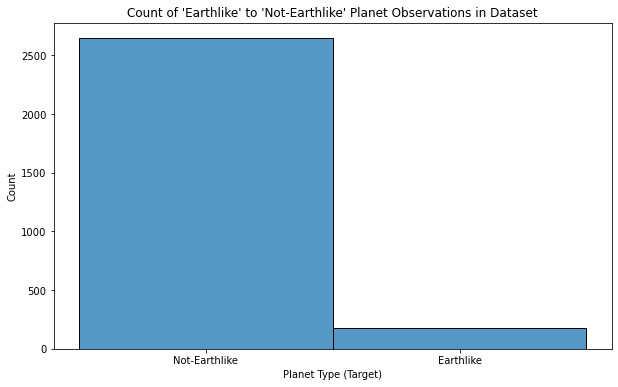

-----

There are 173 Earthlike planets (6.0% of total) and 2647 Non-Earthlike planets (94.0% of total).


In [7]:
# Plots a histogram of Not-Earthlike to Earthlike Planets in the Dataset
plt.figure(figsize = (10,6))
plt.title("Count of 'Earthlike' to 'Not-Earthlike' Planet Observations in Dataset")
plt.xlabel('Planet Type (Target)')
sns.histplot(data = df.y)
plt.show()

# Add in a value count and value percentage by setting each y condition to a variable
print('-----\n')
e_y = df[df.y == 'Earthlike'].count()
e_n = df[df.y == 'Not-Earthlike'].count()
print(f'There are {e_y.y} Earthlike planets ({100*(e_y.y/(e_y.y + e_n.y)).round(2)}% of total) and {e_n.y} Non-Earthlike planets ({100*(e_n.y/(e_y.y + e_n.y)).round(2)}% of total).')


### *Since this is only 6% of the planets in this dataset, itself only 56% of the total planets discovered, I decided to keep all outliers in an attempt to maximize the number of observations to use.  At the same time, I can minimize the outlier effect through scaling and clustering.*

# $\bigstar$ Exploratory Data Analysis and Feature Engineering

## Split the Data

In [8]:
# Split into trainm validate and test
train, validate, test = wrangle.splitter(df)

Train = 1579 rows (56.0%) | Validate = 677 rows (24.0%) | Test = 564 rows (20.0%)
You did not stratify.  If looking to stratify, ensure to add argument: "target = variable to stratify on".


In [9]:
# Quick look at train
train.info()
train.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 1579 entries, Kepler-317-b to Kepler-903-b
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num_planets_in_sys        1579 non-null   int64  
 1   orbital_period            1579 non-null   float64
 2   y                         1579 non-null   object 
 3   star_temp                 1579 non-null   float64
 4   metallicity               1579 non-null   float64
 5   luminosity                1579 non-null   float64
 6   star_age                  1579 non-null   float64
 7   star_mass                 1579 non-null   float64
 8   star_density              1579 non-null   float64
 9   star_radius               1579 non-null   float64
 10  star_distance_from_earth  1579 non-null   float64
 11  multistar                 1579 non-null   int64  
 12  discovery_order           1579 non-null   int64  
 13  y_encoded                 1579 non-null   int64  

,num_planets_in_sys,orbital_period,y,star_temp,metallicity,luminosity,star_age,star_mass,star_density,star_radius,star_distance_from_earth,multistar,discovery_order,y_encoded
planet,,,,,,,,,,,,,,
Kepler-317-b,2,5.524177,Not-Earthlike,5445.60,0.2140,-0.20800,7.66,0.942222,1.868017,0.938182,940.584,0,1,0
Kepler-220-c,4,9.034198,Not-Earthlike,4589.74,-0.1665,-0.68725,7.16,0.702000,10.347129,0.699167,171.109,0,2,0


##### I worked on train only from here forward to not leak into the out of sample data.

### I proceeded to optimize the feature set for analysis using bivariate and mutlivariate analysis, as well as a cluster-based stellar feature elaborated below.  I had a very general question to answer: which characteristics - numeric and categorical - are statistically signifigant when comparing the differences between stars with Earthlike planets with those without?

## Examining categoricals:

In [10]:
# ID categorical features
features_to_chi_square_test = ['num_planets_in_sys','discovery_order','multistar']

num_planets_in_sys
Note: Dashed line indicates percent of all stars with Earthlike planets


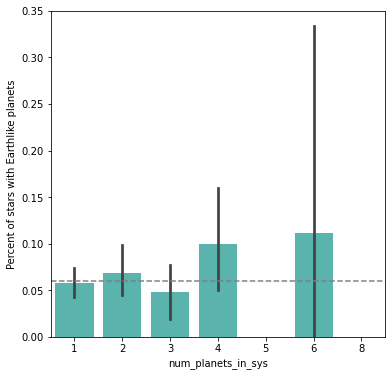

chi2 = 7.191529879286361, p = 0.30349740065174396
We fail to reject the null hypothesis.

-----

discovery_order
Note: Dashed line indicates percent of all stars with Earthlike planets


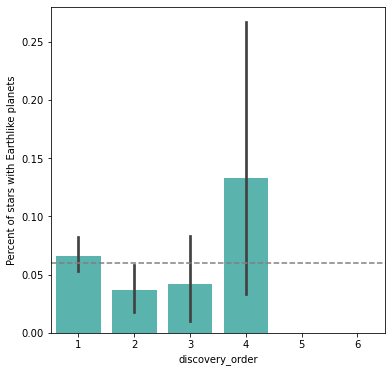

chi2 = 7.395523006493354, p = 0.19284693143357282
We fail to reject the null hypothesis.

-----

multistar
Note: Dashed line indicates percent of all stars with Earthlike planets


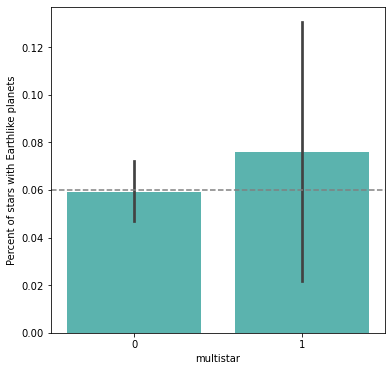

chi2 = 0.1900250016722465, p = 0.6628958096594963
We fail to reject the null hypothesis.

-----



In [11]:
# Run a loop to print barplots and hypothesis tests for each categorical
for col in features_to_chi_square_test:
    print(col)
    print('Note: Dashed line indicates percent of all stars with Earthlike planets')
    plt.figure(figsize=(6,6))
    sns.barplot(x = col, y = 'y_encoded', data=train, alpha=.8, color='lightseagreen')
    plt.ylabel('Percent of stars with Earthlike planets')
    plt.axhline(train['y_encoded'].mean(), ls='--', color='gray')
    plt.show()
    observation = pd.crosstab(train['y_encoded'], train[col])
    chi2, p, degf, expected = stats.chi2_contingency(observation)
    print(f'chi2 = {chi2}, p = {p}')
    if p < .05:
        print('We reject the null hypothesis.')
    else: 
        print('We fail to reject the null hypothesis.')
    print('\n-----\n')

##### We fail to reject the null hypothesis that there is any difference between any of these groups when it comes to having an Earthlike planet.

## Examining Numericals:

##### All numericals were examed in 'exoplanet_clustering_and_EDA_scrapbook.ipynb'.  In summary:
- The only features where the means are different are:
    - Metallicity
    - Orbital Period
    - Distance from Earth
    
##### Here is Metallicity as an example:

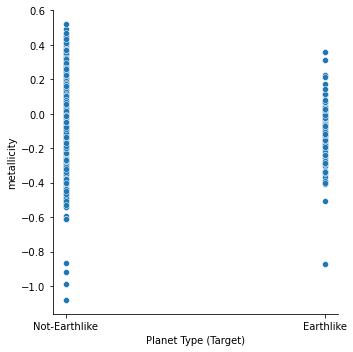

t = -4.172131292981905, p = 3.1820878661487445e-05
We reject the null hypothesis that Earthlike planets differ in metallicity than non-earthlike planets.


In [12]:
# Set confidence level
alpha = .05

# Plot Metallicity for Earthlike and Not-Earthlike
sns.relplot(data = train, x='y', y='metallicity')
plt.xlabel('Planet Type (Target)')
plt.show()

# Hypothesis Test
a = train[train.y == 'Earthlike']
b = train[train.y == 'Not-Earthlike']
t, p = stats.ttest_ind(a['metallicity'], b['metallicity'], equal_var=True)
print(f't = {t}, p = {p}')
if p < alpha:
    print('We reject the null hypothesis that Earthlike planets differ in metallicity than non-earthlike planets.')
else: print('We fail to reject the null hypothesis that Earthlike planets differ in metallicity than non-earthlike planets.')

### *Of special note, one of the numericals, 'star_distance_from_earth', did fail to reject the null, meaning the distance from earth does impact whether or not a star has an Earthlike planet.  However, this is unrelated to the star or planet itself, and is likely due to measurements being better at closer range.*
#### In the future, this distance could be taken into account when weighing the strength of the planet and star characteristics to improve classification.

## Building a Stellar Cluster Feature:

#### In an initial correlation heatmap, I saw that a number of star characteristics were correlated.  Through research, I discovered that the mass, radius, temperature, density and luminosity are all related.  Specifically Luminosity is proportional to the square of the radius and fourth power of the Temperature.
#### After examining numerous clusterings of these characteristics, I discovered nice clusters around Luminosity and Temperature.  This aligns with the [Main Sequence](https://en.wikipedia.org/wiki/Main_sequence) model of stellar bodies.  Because of the physics of very large bodies begins to simplify statistically, almost all stars spend their productive years in a well-defined zone.

$Luminosity = \sigma * 4 * \pi * r^2 * T^4$

where,
- $\sigma$ is the Bolzmann's constant
- r = Star Radius, relative to Sun (star_radius)
- T = Star Temperature, in K (start_temp)    

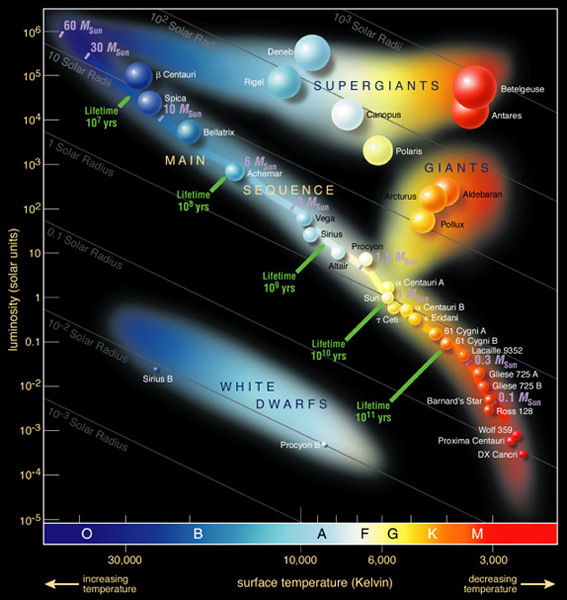

Using a k-elbow it was determined 4-clusters were optimal.

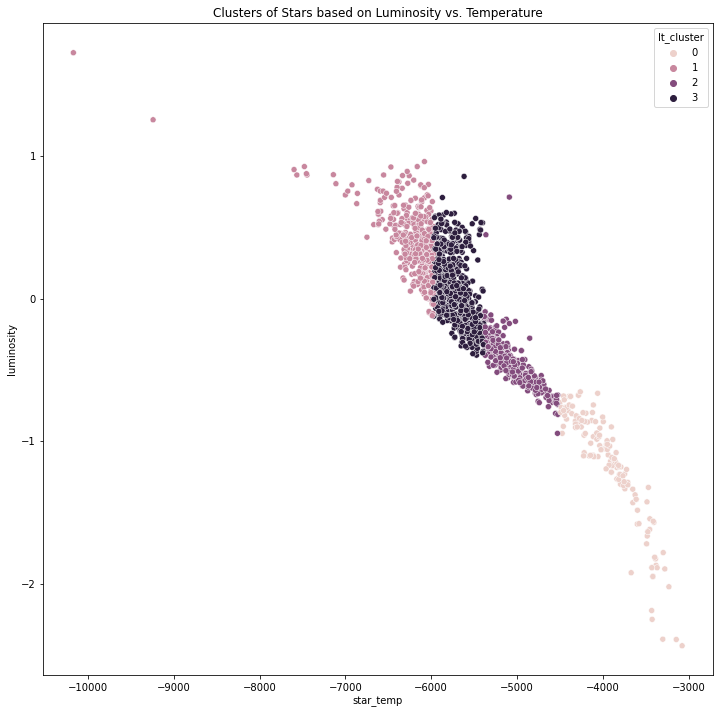

In [13]:
# Isolate Features of interest
X = train[['luminosity','star_temp']]

# Create and fit the model
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

# Create clusters based off the model
train['lt_cluster'] = kmeans.predict(X)

# Plot the clusters, with star_temp reversed to reflect main sequence diagram
plt.figure(figsize = (12,12))
sns.scatterplot(data=train, x=(train.star_temp*-1),y=(train.luminosity),hue='lt_cluster')
plt.title('Clusters of Stars based on Luminosity vs. Temperature')
plt.show()

### Cluster Impact

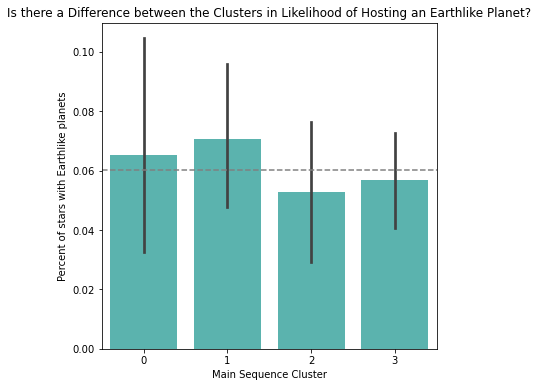

t = -0.8263271892794748, p = 0.4087435128182373
We fail to reject the null hypothesis that Earthlike planets differ in metallicity than non-earthlike planets.


In [14]:
# Plot Clusters compared to Earthlike percentage
plt.figure(figsize=(6,6))
plt.title('Is there a Difference between the Clusters in Likelihood of Hosting an Earthlike Planet?')
sns.barplot(x = 'lt_cluster', y = 'y_encoded', data=train, alpha=.8, color='lightseagreen')
plt.axhline(train['y_encoded'].mean(), ls='--', color='gray')
plt.ylabel('Percent of stars with Earthlike planets')
plt.xlabel('Main Sequence Cluster')
plt.show()

# Hypothesis Test
a = train[train.y == 'Earthlike']
b = train[train.y == 'Not-Earthlike']
t, p = stats.ttest_ind(a['lt_cluster'], b['lt_cluster'], equal_var=True)
print(f't = {t}, p = {p}')
if p < alpha:
    print('We reject the null hypothesis that Earthlike planets differ in metallicity than non-earthlike planets.')
else: print('We fail to reject the null hypothesis that Earthlike planets differ in metallicity than non-earthlike planets.')

### Unfortunately, looks like after all that excitement, the clusters don't seem to differ in predicting Earthlike or not.

## Summary of Exploration:
1. There is no difference in stars with Earthlike planets when comparing across categorical features.
2. Metallicity is the only stellar feature that showed a difference between earthlike and non-earthlike (Earthlike planets are more likely found with stars of a higher metallicity, which makes sense since rocky planets are more likely to form from a proto-system higher in metals to begin with.
3. Orbital period is also different between Earthlike and Not-Earthlike.  While seemingly a planetary cahracteristic (which would remove it from analysis), I left it in the analysis because it is technically a combination of star and planet characteristics.  Earthlike planets have much lower mean periods than not-earthlike planets, which also tracks with obervation as rocky planets tend to orbit closer to their stars.  
4. There are more Earthlike planets found closer to earth, but this is likely because our instruments are better at detecting them at these distances.
5. In order to consolidate characteristics into best features, the best clustering seemed to follow the established science of grouping stars along the "Main Sequence" line.  Unfortunately, that did not show impact, but hopefully can contribute to the a good classification model.

# $\bigstar$ Modeling

##### Following this exploration, the data was cleaned once more by dropping features captured by others, and then scaled and split into modeling sets.

In [15]:
# Create cleaned, split, scaled, and seperated modeling datasets
train, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.final_clean(train, validate, test)

In [16]:
# Quick check one set, the validate target
y_validate.sample(5)

Kepler-1450-b    Not-Earthlike
Kepler-1173-b        Earthlike
Kepler-1011-b    Not-Earthlike
Kepler-1162-b    Not-Earthlike
Kepler-30-c      Not-Earthlike
Name: y, dtype: object

## Baseline Model

In [17]:
# Calculate baseline accuracy pecentage
baseline = y_train.mode()
matches_baseline_prediction = (y_train == baseline.values[0])
baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.94


### *This accuracy is pretty high, and its because by far most planets are NOT earthlike!  Because of this, and the positive case being 'Earthlike', Accuracy is probably not as important as Sensitivity (Recall) as False Negatives are better than False Positives, because we don't want to waste resources going after true negatives.*

## Modeling

### I tried four different classification models (Decision Tree, Random Forest, KNN, Logistical Regression) with a number of hyperparameters.
- *Modeling can be found in 'exoplanet_modeling_scrapbook.ipynb'*

### Decision Trees of various depths looked promising.  Depth of 8 in particular:

True Positive = 51
False Positive = 8
True Negative = 1476
False Negative = 44
Precision = 0.86
Recall = 0.54
Accuracy = 0.97
F1 Score = 0.66
Support, Positive = 95
Support, Negative = 1484


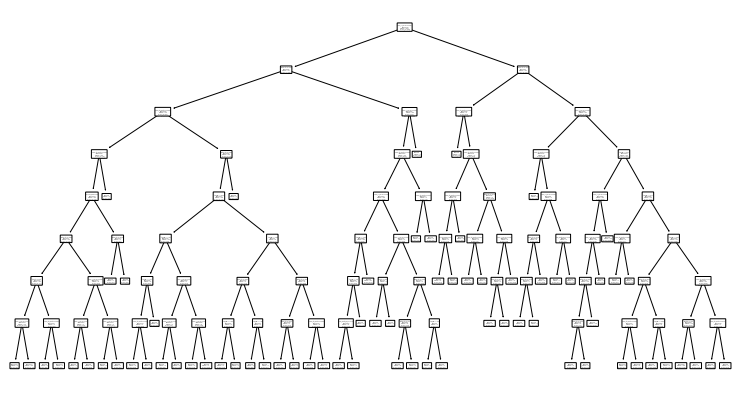

In [18]:
# Decision Tree with k=8 leaves
tree = DecisionTreeClassifier(max_depth=8, random_state=123)
tree = tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_train)
result = pd.DataFrame(confusion_matrix(y_train, y_tree_pred))
results = matrix_result_2d(result)
results['model'] = 'Decision Tree, Depth = 8'

# Print Summary 
matrix_result_2d(result, output='print')

# Plot Tree
plt.figure(figsize=(13, 7))
plot_tree(tree, feature_names=X_train.columns, class_names=tree.classes_, rounded=True)
plt.show()

### Unfortunately, when checking against validation data, it was clear the Decision Tree was a rapid overfitter.   No hyperparameter setting provided any improvement over Baseline Accuracy, and the models only had better recall *after* the accuracy was lower than baseline.

In [19]:
# Decision Tree with k=8 leaves
tree = DecisionTreeClassifier(max_depth=8, random_state=123)
tree = tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_validate)
result = pd.DataFrame(confusion_matrix(y_validate, y_tree_pred))
results = matrix_result_2d(result)
results['model'] = 'Decision Tree, Depth = 8'

# Print Summary 
matrix_result_2d(result, output='print')

True Positive = 1
False Positive = 14
True Negative = 622
False Negative = 40
Precision = 0.07
Recall = 0.02
Accuracy = 0.92
F1 Score = 0.04
Support, Positive = 41
Support, Negative = 636


### Still, let's try testing on Out-of-Sample Data:

In [20]:
# Decision Tree with k=8 leaves on out-of-sample data
tree = DecisionTreeClassifier(max_depth=8, random_state=123)
tree = tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_test)
result = pd.DataFrame(confusion_matrix(y_test, y_tree_pred))
results = matrix_result_2d(result)
results['model'] = 'Decision Tree, Depth = 8'
matrix_result_2d(result, output='print')

True Positive = 1
False Positive = 25
True Negative = 502
False Negative = 36
Precision = 0.04
Recall = 0.03
Accuracy = 0.89
F1 Score = 0.03
Support, Positive = 37
Support, Negative = 527


# $\bigstar$ Conclusions

## Key Findings
- The only appreciable stellar feature found was Metallicity.
- Earthlike planets are typically found closer to their star than non-earthlike planets.
- Unsurprisingly, we are better at identifying planets when they are closer to earth.
- In general, this is cutting edge data capture and exoplanet analysis is still in its infancy in many ways.  More stars will be discovered soon, with better data, so this area is study is ripe for continuation and improvement.

## Model Effectiveness
- An effective model was not found during this project.

## Recommendations and Next Steps
- Continue to cluster stellar characteristics in an attempt to find one statistically signifigant as a indicator of the likelihood of Earthlike planets.
- Build an imputing algorithm to capture a number of planets that had nulls that could not be filled simply by combing and finding the mean of all avaialbe data for that planet.
- Focus early JWST studies on building a dataset which allows for modeling the likelihood of a star having an earthlike planet, as this will make it a better tool in the long run by continually improving its targeting.